# Figure 2: Motion energy & rectification

In [1080]:
from setup_nb import *
from detector.stimulus import FastDiscretePhi, FastSine

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Test

In [902]:
def normalize(x):
    return x - x.mean()

In [922]:
def get_spectrum(image, log=False, rectified=None):
    
    # Put image on global contrast scale:
    image_ = normalize(image)
    
    # Rectification:
    if rectified is not 0:
        image_ = normalize(np.maximum(0, rectified * image_))
    
    # Get power spectrum:
    m = np.abs(np.fft.fftshift(np.fft.fft2(image_)))**2
    
    # Convert do db scale:
    if log:
        m = 20 * np.log10(m + 0.001 * m.mean())
        
    # Extract leftward/rightward energy:
    
    idx1, idx2 = m.shape[0] // 2, m.shape[1] // 2
    e1, e2 = m[:idx1, :idx2].mean(), m[:idx1, idx2+1:].mean()
    
    return m, e1, e2, image_

In [903]:
def noisegrating(ds=1.0, dt=0.01, vel=100.0, depth=20, duration=1.0, nd=False, recfield=180.0):
    
    stim = []
    lambdas = np.random.uniform(ds * 2, ds * 20, size=depth)
    phaseshifts = np.random.uniform(0, 360, size=depth)
    
    for lam, ps in zip(lambdas, phaseshifts):
        grating = 1/ lam * FastSine(lam=lam, vel=vel, duration=duration, nd=nd, start=0.0, stop=duration, phaseshift=ps)\
            .render(recfield, ds, dt)
        stim.append(grating)
    
    s = np.array(stim).mean(axis=0).squeeze()
    n = max(np.abs(s.min()), np.abs(s.max()))
    s = s / n
    
    return s

In [897]:
def get_spectra(stimulus, stimname):
        
    spectra = []
    images = []
    dfs = []
    
    for rect in [-1, 0, 1]:
        power, left, right, image = get_spectrum(stimulus, log=False, rectified=rect)
        spectra.append(power)
        images.append(image)
        
        # Normalize energies:
        maxval = np.maximum(left, right)
        left, right = left / maxval, right / maxval
        
        dfs.append({
                'Stimulus': stimname,
                'Energy': left,
                'Direction': 'Left',
                'Rectification': rect
            })

        dfs.append({
            'Stimulus': stimname,
            'Energy': right,
            'Direction': 'Right',
            'Rectification': rect
        })
        
    return np.array(images), np.array(spectra), pd.DataFrame(dfs)

In [931]:
# Stimuli:

velocity = 60.0
lam = 60.0
duration = 1.00
nd = False
fov = 90.0
dt = 0.01
ds = 2.0

dfs = []

# Noise:
stim1 = noisegrating(ds=ds, dt=dt, vel=velocity, depth=30, duration=duration, nd=nd, recfield=fov)
images1, spectra1, df1 = get_spectra(stim1, "Translating noise")

# Single sine:
stim2 = FastSine(lam=lam, vel=velocity, duration=duration, start=0.0, stop=duration, nd=nd, phaseshift=0.0)\
    .render(recfield=fov, delta_phi=ds, dt=dt)
images2, spectra2, df2 = get_spectra(stim2, "Translating grating")    

# Discrete sine:
stim3 = FastDiscretePhi(lam=lam, vel=velocity, duration=duration, start=0.0, stop=duration, flip=False, nd=nd)\
    .render(recfield=fov, delta_phi=ds, true_dt=dt)
images3, spectra3, df3 = get_spectra(stim3, "Discretized grating")

# Reverse-phi:
stim4 = FastDiscretePhi(lam=lam, vel=velocity, duration=duration, start=0.0, stop=duration, flip=True, nd=nd)\
    .render(recfield=fov, delta_phi=ds, true_dt=dt)
images4, spectra4, df4 = get_spectra(stim4, "Reverse-phi stimulus")

df = pd.concat([df1, df2, df3, df4])

### Panels

In [1088]:
def panel_stimulus(ax, stim):
    
    ax.imshow(stim.T, interpolation="nearest", cmap="gray_r", aspect="auto",
              vmin=-1, vmax=1, extent=[0, 90, 1, 0])
    
    ax.xaxis.set_ticks([0, 45, 90])
    ax.yaxis.set_ticks([0, 0.5, 1.0])
    
    ax.set_xlabel(u"Space (°)", labelpad=2.0)
    ax.set_ylabel("Time (s)", labelpad=2.0)
    
    ax.tick_params(axis='both', which='major', pad=2)
    
    sb.despine(ax=ax)

In [1112]:
def panel_fourier(ax, spec):
        
    # Calculate boundaries:
    b1 = np.fft.fftshift(np.fft.fftfreq(spec.shape[0], d=ds))
    b2 = np.fft.fftshift(np.fft.fftfreq(spec.shape[1], d=dt))
        
    ax.imshow(np.sqrt(spec.T), interpolation="nearest", cmap="gray_r", aspect="auto",
              extent=[b2[0], b2[-1], b1[0], b1[-1]], vmin=0.0, vmax=110.0, zorder=0)
    
    ax.set_ylim([-0.05, 0.05])
    ax.set_xlim([-20, 20])
    
    ax.xaxis.set_ticks([-20, 0, 20])
    ax.yaxis.set_ticks([-0.05, 0, 0.05])
    
    ax.tick_params(axis='both', which='major', pad=2)
    
    ax.set_xlabel(u"$\mathregular{f_s}$ (cycles/°)", labelpad=1.5)
    ax.set_ylabel("$\mathregular{f_t}$ (cycles/s)", labelpad=-3)
    
    where = 0.0
    
    l = ax.plot(ax.get_xlim(), [where, where], linestyle="dotted", zorder=1, color="#444444")
    l[0].set_dashes([1, 1])

    l = ax.plot([where, where], ax.get_ylim(), linestyle="dotted", zorder=1, color="#444444")
    l[0].set_dashes([1, 1])
    
    from matplotlib.patches import Rectangle
    
    myrect = Rectangle([1, 0.003], 18, 0.044, fill=None, alpha=1, zorder=2, color=gt_colors["PD"], lw=1.0)
    ax.add_patch(myrect)
    
    myrect = Rectangle([-19, 0.003], 18, 0.044, fill=None, alpha=1, zorder=2, color=gt_colors["ND"], lw=1.0)
    ax.add_patch(myrect)
    
    myrect = Rectangle([-19, -0.047], 18, 0.044, fill=None, alpha=1, zorder=2, color=gt_colors["PD"], lw=1.0)
    ax.add_patch(myrect)
    
    myrect = Rectangle([1, -0.047], 18, 0.044, fill=None, alpha=1, zorder=2, color=gt_colors["ND"], lw=1.0)
    ax.add_patch(myrect)
    
#     sb.plt.arrow(4, 0.04, 4, 0, head_width=0.005, head_length=1, fc=gt_colors["PD"], ec=gt_colors["PD"], lw=1.5)
#     sb.plt.arrow(-12, 0.04, -4, 0, head_width=0.005, head_length=1, fc=gt_colors["ND"], ec=gt_colors["ND"], lw=1.5)

    ax.annotate("",
                xy=(8, 0.04), xycoords='data',
                xytext=(4, 0.04), textcoords='data',
                arrowprops=dict(arrowstyle="-|>", facecolor=gt_colors["PD"], edgecolor="black"))

    ax.annotate("",
            xy=(-13, 0.04), xycoords='data',
            xytext=(-19, 0.04), textcoords='data',
            arrowprops=dict(arrowstyle="<|-", facecolor=gt_colors["ND"], edgecolor="black"))
    
    sb.despine(ax=ax)

In [1089]:
def panel_energy(ax, df, stimid, legend=False):
    
    mydat = df[df.Stimulus == stimid]
    
    palette = {
        'Left': gt_colors["ND"],
        'Right': gt_colors["PD"],
    }
    
    sb.barplot(x="Rectification", y="Energy", hue="Direction", data=mydat, order=[0, 1, -1], #linewidth=0.0,
               hue_order=["Right", "Left"], palette=palette)
    
    sb.despine(ax=ax)
    
    ax.set_xlabel("Rectification", labelpad=2.0)
    ax.set_ylabel("Average energy")
    
    ax.tick_params(axis='both', which='major', pad=2)

    ax.set_ylim([-0.1, 1.1])
    add_refline(ax, horizontal=True)
    
    ax.set_yticks([])
    
    ax.set_xticklabels(["None", "ON", "OFF"])
    
    ax.legend_.remove()
    
    ax.patch.set_alpha(0.0)

In [2]:
def illustration_figure():
    
    off = 1.4
    off_v = -17.7
    rows = [0, 2.8]
    panelsize = (1.7, 1.7)
    
    fig = sb.plt.figure(figsize=[2.65, 3.5])
#     fig.suptitle("Leonhardt et al. (2017): Figure 2", fontsize=14)
    
    # Noise:
    
    height = 24 + off_v
    
    ax = addaxis(fig, (off + rows[0], height), panelsize, letter="a", nudge=0.0)
    panel_stimulus(ax, stim1)
    remove_axis(ax, x=True)
    
    ax = addaxis(fig, (off + rows[1], height), panelsize, letter="b", nudge=0.3)
    panel_fourier(ax, spectra1[1, :, :])

    # Discrete sine:
    
    height = 21.5 + off_v
    
    ax = addaxis(fig, (off + rows[0], height), panelsize, letter="c", nudge=0.0)
    panel_stimulus(ax, stim3)
    remove_axis(ax, x=True)
    
    ax = addaxis(fig, (off + rows[1], height), panelsize, letter="", nudge=0.0)
    panel_energy(ax, df, "Discretized grating", legend=False)
    remove_axis(ax, x=True)

    # Discrete reverse:
    
    height = 19.15 + off_v
    
    ax = addaxis(fig, (off + rows[0], height), panelsize, letter="d", nudge=0.0)
    panel_stimulus(ax, stim4)
    
    ax = addaxis(fig, (off + rows[1], height), panelsize, letter="", nudge=0.0)
    panel_energy(ax, df, "Reverse-phi stimulus", legend=False)
    
    fig.set_frameon(False)
    fig.savefig("../output/Fig2.tif", format="tiff", dpi=standard_dpi)

### Plots

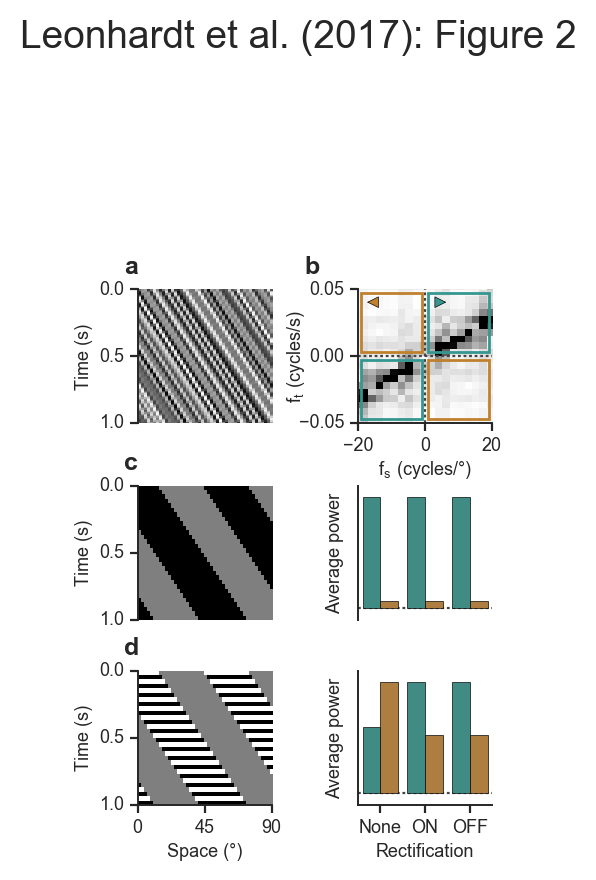

In [1115]:
illustration_figure()